In [1]:
from IPython.display import SVG
import numpy as np
from sknetwork.data import karate_club, painters, movie_actor
from sknetwork.clustering import Louvain, get_modularity
from sknetwork.linalg import normalize
from sknetwork.utils import get_membership
from sknetwork.visualization import visualize_graph, visualize_bigraph


[0 1 2 3] [12 11  6  5]


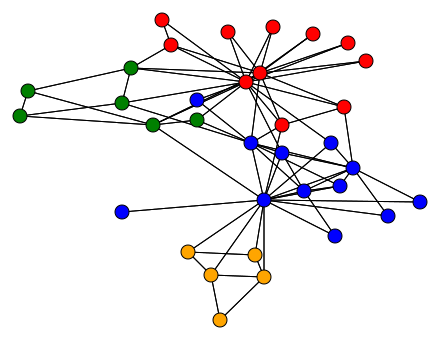

In [12]:
graph = karate_club(metadata=True)
adjacency = graph.adjacency
position = graph.position

louvain = Louvain()
labels = louvain.fit_predict(adjacency)

labels_unique, counts = np.unique(labels, return_counts=True)
print(labels_unique, counts)

image = visualize_graph(adjacency, position, labels=labels)
SVG(image)

In [13]:
graph

{'adjacency': <Compressed Sparse Row sparse matrix of dtype 'bool'
 	with 156 stored elements and shape (34, 34)>,
 'labels': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'position': array([[ 0.04, -0.33],
        [ 0.24, -0.15],
        [ 0.01, -0.01],
        [ 0.13, -0.28],
        [ 0.02, -0.64],
        [-0.08, -0.75],
        [ 0.04, -0.76],
        [ 0.21, -0.25],
        [ 0.08,  0.09],
        [-0.11,  0.23],
        [-0.13, -0.62],
        [-0.28, -0.4 ],
        [ 0.2 , -0.53],
        [ 0.08, -0.07],
        [ 0.23,  0.55],
        [ 0.06,  0.64],
        [-0.06, -1.  ],
        [ 0.32, -0.42],
        [ 0.15,  0.6 ],
        [ 0.19, -0.01],
        [ 0.27,  0.45],
        [ 0.39, -0.34],
        [-0.04,  0.61],
        [-0.26,  0.41],
        [-0.51,  0.14],
        [-0.49,  0.28],
        [-0.19,  0.68],
        [-0.28,  0.21],
        [-0.11,  0.12],
        [-0.17,  0.54],
        [ 0.22,  0.19],

In [15]:
from neo4j import GraphDatabase
from sknetwork.data import from_csv
import os

db_url = os.getenv("DB_HOST", "neo4j://localhost:7687")
db_user = os.getenv("DB_USER", "neo4j")
db_pass = os.getenv("DB_PASSWORD", "no_password")
db_base = os.getenv("DB_DATABASE", "neo4j")
label_model = os.getenv("LABEL_MODEL", "openai/gpt-4o-mini")

csv_temp = "/tmp/communities_neo4j_export.csv"

if not os.path.isfile(csv_temp):
	print("Connecting to db")
	with GraphDatabase.driver(db_url, auth=(db_user, db_pass)) as driver:
		driver.verify_connectivity()

		print("Fetching database as csv")
		records, _, _ = driver.execute_query("""
			CALL apoc.export.csv.all(null, {stream:true})
			YIELD file, nodes, relationships, properties, data
			RETURN file, nodes, relationships, properties, data
		""")
		_, n_nodes, n_relationships, _, csv_contents = records[0]
		print(f"Downloaded {n_nodes} nodes, {n_relationships} relationships")

		print("Saving as temporary file")
		with open(csv_temp, "w") as f:
			f.write(csv_contents)

print("Loading databse from file")
graph = from_csv(csv_temp)


Loading databse from file


In [ ]:
from sknetwork.visualization import visualize_graph

positions = skn.
image = visualize_graph(graph.adjacency, positions)
SVG(image)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [10]:
graph

{'names': array(['', '0', '1', ..., 'written plan', 'written plans',
        'written witness statements'], shape=(11994,), dtype='<U122'),
 'adjacency': <Compressed Sparse Row sparse matrix of dtype 'int64'
 	with 68597 stored elements and shape (11994, 11994)>}